
# DC reisitivity data 
## modelling and inversion

This is modified (simplified) from the script https://www.pygimli.org/_examples_auto/joint_inversion/plot_1_dcem.html


In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import pygimli as pg
from pygimli.mplviewer import drawModel1D
import warnings
warnings.filterwarnings('ignore') # just to make it cleaner in the notebook

In [2]:
transRhoa = pg.RTransLog()
transThk = pg.RTransLog()
transRes = pg.RTransLogLU(1., 1000.)

## Forward model



In [3]:
noiseDC = 3.  # in per cent
lamDC = 500.  # regularization strength
verbose = False

First we create a synthetic model.



In [111]:
nlay = 3  # number of layers
thk = pg.RVector(nlay - 1, 15.0)  # 15m thickness each
res = pg.RVector(nlay, 200.0)  # 200 Ohmm
res[1] = 10.
res[2] = 50.
model = pg.cat(thk, res)  # paste together to one model

<IPython.core.display.Javascript object>


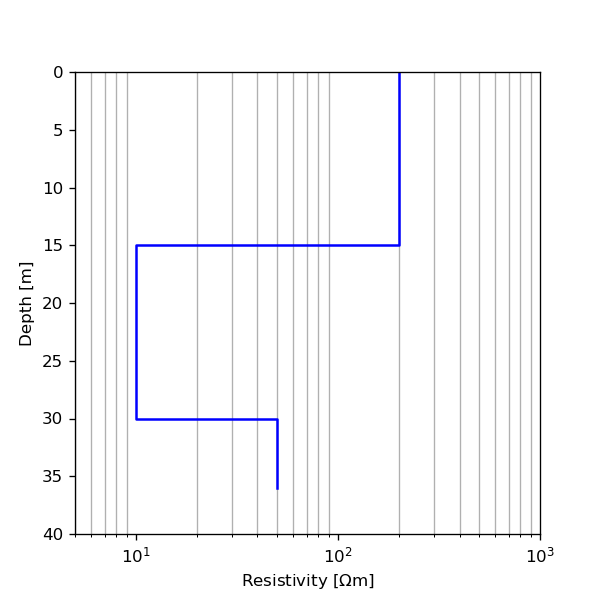

In [112]:
fig,ax = plt.subplots(1, figsize=(5, 5))
drawModel1D(ax, thk, res, plot='semilogx', color='blue')
#ax.legend(('syn'))
ax.set_xlim((5, 1000.))
ax.set_ylim((40., 0.))
ax.grid(which='both')

Next we set up the DC forward operator and generate synthetic data with noise



In [113]:
ab2 = pg.RVector(20, 3.)
na = len(ab2)
mn2 = pg.RVector(na, 1.0)
for i in range(na-1):
    ab2[i+1] = ab2[i] * 1.3
fDC = pg.DC1dModelling(nlay, ab2, mn2)
dataDC = fDC(model)
for i in range(len(dataDC)):
    dataDC[i] *= 1. + np.random.randn(1)[0] * noiseDC / 100.

fDC.region(0).setTransModel(transThk)
fDC.region(1).setTransModel(transRes)

In [114]:
dat1=np.asarray(dataDC);a1=np.asarray(ab2);m1=np.asarray(mn2)
dat1,a1,m1

(array([198.52341592, 193.07572698, 196.68163201, 189.49499015,
        181.88785472, 193.92265932, 170.43174594, 150.98224623,
        123.33243199,  91.2444502 ,  59.95300754,  39.6976622 ,
         29.6696533 ,  30.43241909,  33.91700543,  37.48147867,
         40.30562137,  44.31987658,  45.38705191,  44.45029124]),
 array([  3.        ,   3.9       ,   5.07      ,   6.591     ,
          8.5683    ,  11.13879   ,  14.480427  ,  18.8245551 ,
         24.47192163,  31.81349812,  41.35754755,  53.76481182,
         69.89425537,  90.86253198, 118.12129157, 153.55767904,
        199.62498275, 259.51247758, 337.36622086, 438.57608711]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.]))

# Inversion

### dat1 are the apparent resistivities<br />a1 are the relative electrode spacings, <br />m1 is just a vector of ones (maybe weights for each electrode? not sure what it's for)
Note that the input data in this example is actually the output of the above modelling. 


In [102]:
# example from the synthetic model:
dat1=np.asarray([206.79244185, 198.32207986, 197.92498001, 195.82072024,\
        200.62595155, 192.89268048, 179.94609753, 149.8761764 ,\
        123.32241509,  93.48568541,  60.03475849,  38.45088226,\
         28.97733703,  30.81854024,  32.9805305 ,  35.51872075,\
         41.86190871,  43.3125642 ,  45.04428067,  44.85161888]);
a1=np.asarray([  3.,   3.9, 5.07,   6.591  ,8.5683    ,  11.13879   ,  14.480427, \
           18.8245551 , 24.47192163,  31.81349812,  41.35754755,  \
           53.76481182, 69.89425537,  90.86253198, 118.12129157, 153.55767904, \
           199.62498275, 259.51247758, 337.36622086, 438.57608711]);
m1=np.asarray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,1., 1., 1.]);

In [103]:
nlay=3 # hypothesis for the number of layers
noiseDC = 3.  # in per cent
lamDC = 2.  # regularization strength
verbose = False
gDC=pg.DC1dModelling(nlay, a1, m1) # create a container with the setup

### recall the "original" input model to plot as reference:
thk = pg.RVector(nlay - 1, 15.0)  # 15m thickness each
res = pg.RVector(nlay, 200.0)  # 200 Ohmm
res[1] = 10.
res[2] = 50.

In [104]:
# We set up the independent DC inversion and let it run.
invDC = pg.RInversion(dat1, gDC, transRhoa, verbose)
modelDC = pg.RVector(nlay*2-1, 20.)
invDC.setModel(modelDC)
invDC.setRelativeError(noiseDC/100.)
invDC.setLambda(lamDC)
invDC.setMarquardtScheme(0.9)
modelDC = invDC.run()
respDC = invDC.response()

## Finally, plot the results and the original model for ref. <br /> Also show the resistivity from the inverted model and its fit with the original data

<IPython.core.display.Javascript object>


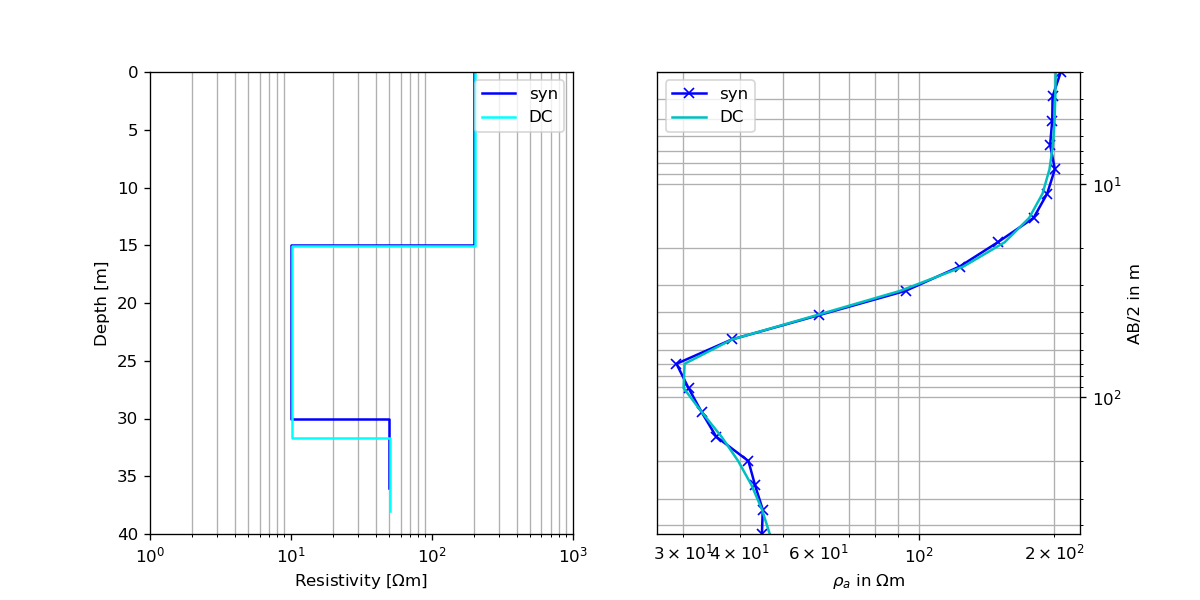

In [105]:
fig = plt.figure(2, figsize=(10, 5))
plt.clf()
ax1 = fig.add_subplot(121)
drawModel1D(ax1, thk, res, plot='semilogx', color='blue')
drawModel1D(ax1, modelDC(0, nlay-1),modelDC(nlay-1, nlay*2-1), plot='semilogx',color='cyan')

ax1.legend(('syn', 'DC', 'JI'))
ax1.set_xlim((1., 1000.))
ax1.set_ylim((40., 0.))
ax1.grid(which='both')

ax3 = fig.add_subplot(122)
ax3.loglog(dat1, a1, 'bx-', label='syn')
ax3.loglog(respDC, a1, 'c-', label='DC')
#ax3.axis('tight')
ax3.set_ylim((max(a1), min(a1)))
ax3.grid(which='both')
ax3.set_xlabel(r"$\rho_a$ in $\Omega$m")
ax3.set_ylabel("AB/2 in m")
ax3.yaxis.set_ticks_position("right")
ax3.yaxis.set_label_position("right")
ax3.legend(loc="best")
pg.wait()

# Another example with "made-up" data <br /> spacings increasing by $\sqrt{2}$ factor <br /> ...or replace by your own!...

In [120]:
#example just made up:
dat1=np.asarray([413.5848837 , 396.64415972, 395.84996002, 391.64144048,
       401.2519031 , 385.78536096, 359.89219506, 299.7523528 ,
       246.64483018, 186.97137082, 120.06951698,  76.90176452,
        57.95467406,  61.63708048,  65.961061  ,  71.0374415 ,
        83.72381742,  86.6251284 ,  90.08856134,  89.70323776])
a1=[0.25*(np.sqrt(2)**i) for i in range(20)];print('spacings:\n',a1)
m1=np.asarray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,1., 1., 1.]);

spacings:
 [0.25, 0.3535533905932738, 0.5000000000000001, 0.7071067811865477, 1.0000000000000002, 1.4142135623730956, 2.000000000000001, 2.8284271247461916, 4.000000000000002, 5.656854249492383, 8.000000000000005, 11.313708498984768, 16.000000000000014, 22.62741699796954, 32.00000000000003, 45.25483399593909, 64.00000000000007, 90.50966799187819, 128.00000000000017, 181.0193359837564]


In [121]:
nlay=3 # hypothesis for the number of layers
noiseDC = 3.  # in per cent
lamDC = 2.  # regularization strength
verbose = False
gDC=pg.DC1dModelling(nlay, a1, m1) # create a container with the setup
invDC = pg.RInversion(dat1, gDC, transRhoa, verbose)
modelDC = pg.RVector(nlay*2-1, 20.)
invDC.setModel(modelDC)
invDC.setRelativeError(noiseDC/100.)
invDC.setLambda(lamDC)
invDC.setMarquardtScheme(0.9)
modelDC = invDC.run()
respDC = invDC.response()

<IPython.core.display.Javascript object>


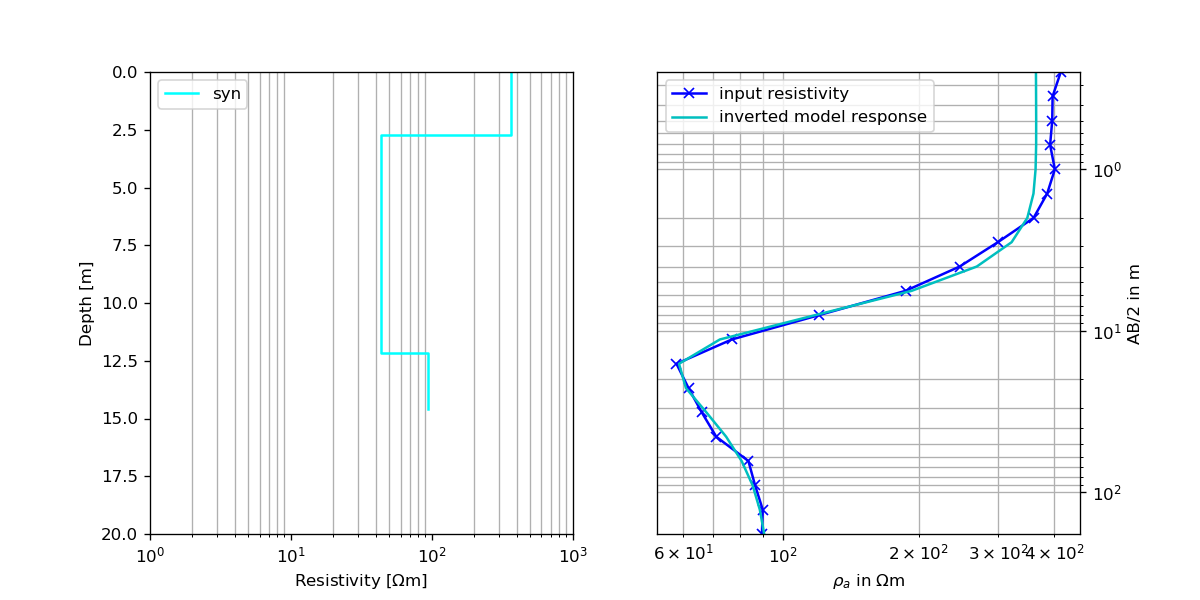

In [122]:
fig = plt.figure(figsize=(10, 5))
fig.clf()
ax1 = fig.add_subplot(121)
drawModel1D(ax1, modelDC(0, nlay-1),modelDC(nlay-1, nlay*2-1), plot='semilogx',color='cyan')

ax1.legend(('syn', 'DC', 'JI'))
ax1.set_xlim((1., 1000.))
ax1.set_ylim((20, 0.))
ax1.grid(which='both')

ax3 = fig.add_subplot(122)
ax3.loglog(dat1, a1, 'bx-', label='input resistivity')
ax3.loglog(respDC, a1, 'c-', label='inverted model response')
#ax3.axis('tight')
ax3.set_ylim((max(a1), min(a1)))
ax3.grid(which='both')
ax3.set_xlabel(r"$\rho_a$ in $\Omega$m")
ax3.set_ylabel("AB/2 in m")
ax3.yaxis.set_ticks_position("right")
ax3.yaxis.set_label_position("right")
ax3.legend(loc="best")
pg.wait()

In [12]:
# Stefan Nielsen, March 2020, modified from the following source:
# Günther, T. (2013): On Inversion of Frequency Domain Electromagnetic Data in
# Salt Water Problems - Sensitivity and Resolution. Ext. Abstr., 19th European
# Meeting of Environmental and Engineering Geophysics, Bochum, Germany.